In [1]:
import uproot
import re
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import torch_geometric.transforms as T

from tqdm.notebook import tqdm
from sklearn.metrics import roc_curve, auc
from tqdm.notebook import tqdm

/lhome/ific/f/fkellere/miniconda/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
fold   = '/lhome/ific/f/fkellere/NEXT_Graphs/weaver-benchmark/weaver/output_PN_RecoBIG_175/'
#source = '/lhome/ific/f/fkellere/Input_Dataframes/MC_dataset_Marija_10mm_SB50.h5'

In [3]:
def PN_analysis(folder, file, test):
    tree = uproot.open(folder+file)['Events']
    ## create a data-frame from all branches included in the TTree
    df = tree.arrays(tree.keys(),library='pd')
    
    if test:
        E = df['E_tot'].values
        
    
    y_test = df['is_signal'].values
    y_pred = df['score_is_signal'].values
            
    # calculate scores
    B_score = []
    S_score = []
    t = tqdm(range(0, len(y_pred)))

    for i in t:
        if y_test[i]==0:
            B_score.append(y_pred[i])
        else:
            S_score.append(y_pred[i])
            
    # create ROC curves and FOM
    fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(y_test, y_pred)
    Seff = []
    Brej = []
    Figm = []
    thre = np.linspace(min(y_pred),max(y_pred),100)
    t    = tqdm(range(0,len(thre)))

    for i in t:
        Seff.append(len([x for x in S_score if x>=thre[i]])/len(S_score))
        Brej.append(1-len([x for x in B_score if x>=thre[i]])/len(B_score))
        Figm.append(len([x for x in S_score if x>=thre[i]])*np.sqrt(len(B_score))/
                (np.sqrt(len([x for x in B_score if x>=thre[i]]))*len(S_score)))
    
    if test:
        return y_test, y_pred, fpr_gnn, tpr_gnn, threshold_gnn, Seff, Brej, Figm, thre, B_score, S_score, E
    else:
        return y_test, y_pred, fpr_gnn, tpr_gnn, threshold_gnn, Seff, Brej, Figm, thre, B_score, S_score

In [4]:
y_test, y_predict, fpr_gnn_tr, tpr_gnn_tr, threshold_gnn_tr, Seff_tr, Brej_tr, Figm_tr, thre_tr, B_score_tr, S_score_tr = PN_analysis(fold,'particlenet_predict_train.root',False)
y_test, y_predict, fpr_gnn_vl, tpr_gnn_vl, threshold_gnn_vl, Seff_vl, Brej_vl, Figm_vl, thre_vl, B_score_vl, S_score_vl = PN_analysis(fold,'particlenet_predict_valid.root',False)
y_test, y_predict, fpr_gnn_te, tpr_gnn_te, threshold_gnn_te, Seff_te, Brej_te, Figm_te, thre_te, B_score_te, S_score_te, E = PN_analysis(fold,'particlenet_predict.root',True)


  0%|          | 0/2450000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/fkellere/ipykernel_133827/3943426300.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  Figm.append(len([x for x in S_score if x>=thre[i]])*np.sqrt(len(B_score))/


  0%|          | 0/1230000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/fkellere/ipykernel_133827/3943426300.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  Figm.append(len([x for x in S_score if x>=thre[i]])*np.sqrt(len(B_score))/


  0%|          | 0/1229420 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/fkellere/ipykernel_133827/3943426300.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  Figm.append(len([x for x in S_score if x>=thre[i]])*np.sqrt(len(B_score))/


In [5]:
Loss   = []
with open(f'{fold}LossFile.out') as f:
    file = f.readlines()
for line in file:
    if 'Train AvgLoss:' in line:
            loss = re.search("\d+\.\d+",line)
            loss = float(loss.group())
            Loss.append(loss)

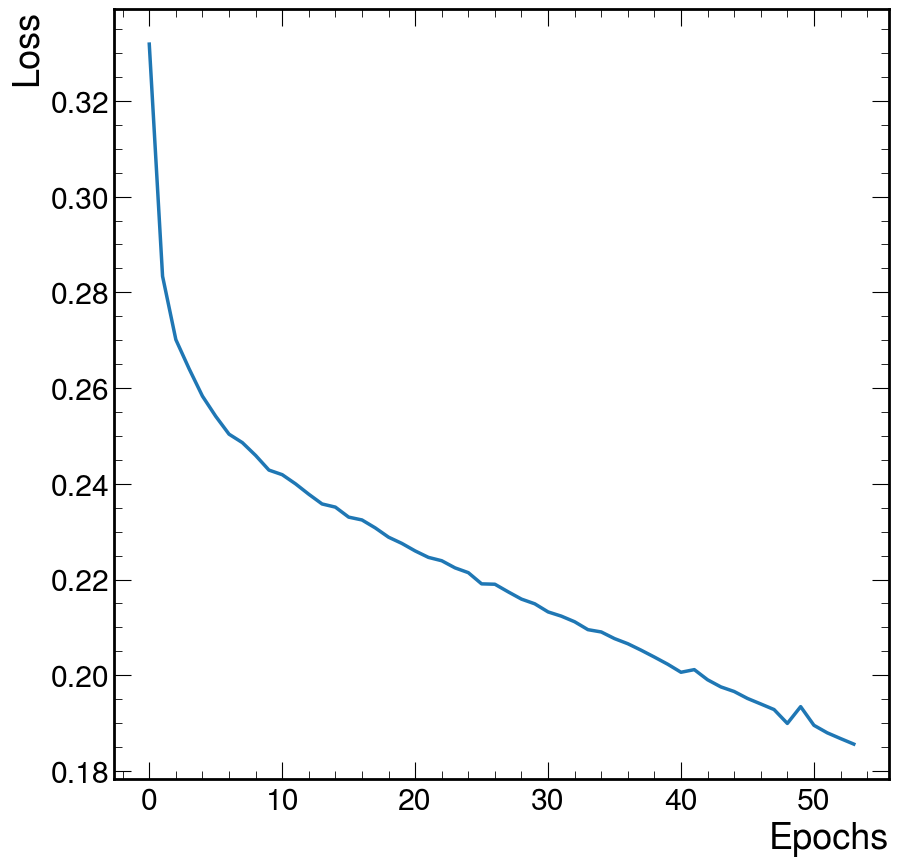

In [6]:
#plt.plot([0.26485,0.17704,0.15878,0.15081,0.14574,0.14199,0.13932,0.13701,0.13548,0.13387,0.13253,0.13134,
#         0.13030,0.12939,0.12259,0.11862,0.11614,0.11504,0.11436,0.11371])
plt.style.use(hep.style.ROOT)
plt.plot(Loss, lw=2.5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig(f'{fold}/Loss.png',bbox_inches='tight')

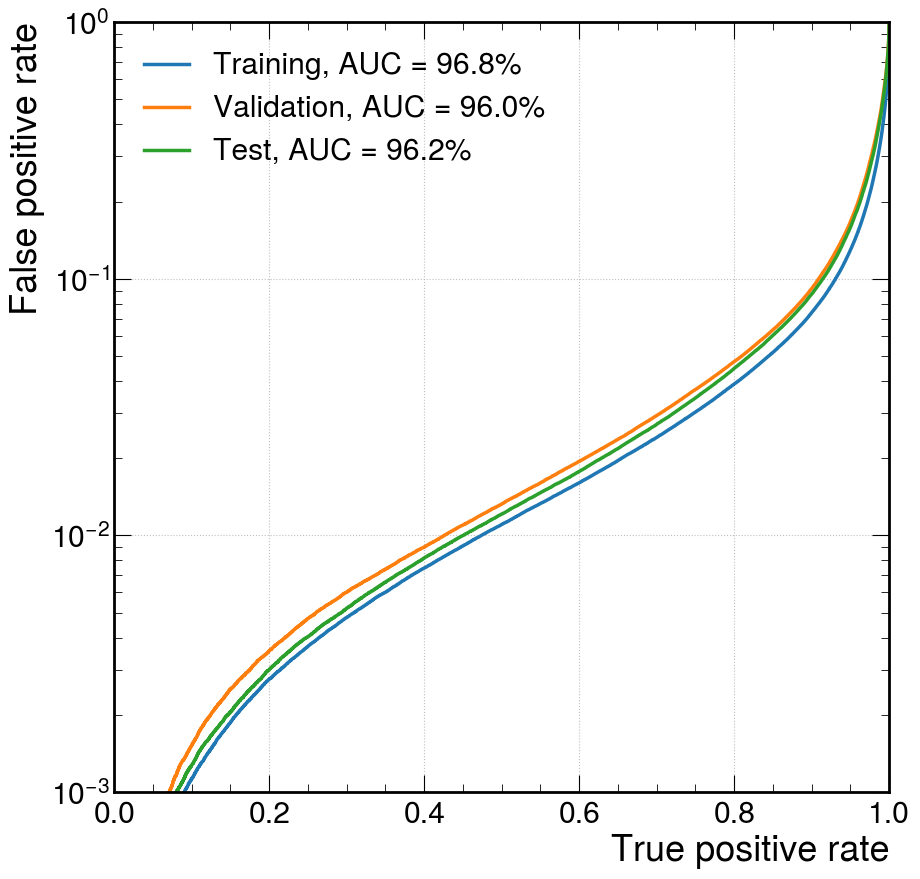

<Figure size 1000x1000 with 0 Axes>

In [7]:
plt.style.use(hep.style.ROOT)
    
# plot ROC curves
plt.figure()
plt.plot(tpr_gnn_tr, fpr_gnn_tr, lw=2.5, label="Training, AUC = {:.1f}%".format(auc(fpr_gnn_tr,tpr_gnn_tr)*100))
plt.plot(tpr_gnn_vl, fpr_gnn_vl, lw=2.5, label="Validation, AUC = {:.1f}%".format(auc(fpr_gnn_vl,tpr_gnn_vl)*100))
plt.plot(tpr_gnn_te, fpr_gnn_te, lw=2.5, label="Test, AUC = {:.1f}%".format(auc(fpr_gnn_te,tpr_gnn_te)*100))
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.semilogy()
plt.ylim(0.001, 1)
plt.xlim(0, 1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()
plt.savefig(f'{fold}/ROC.png',bbox_inches='tight')

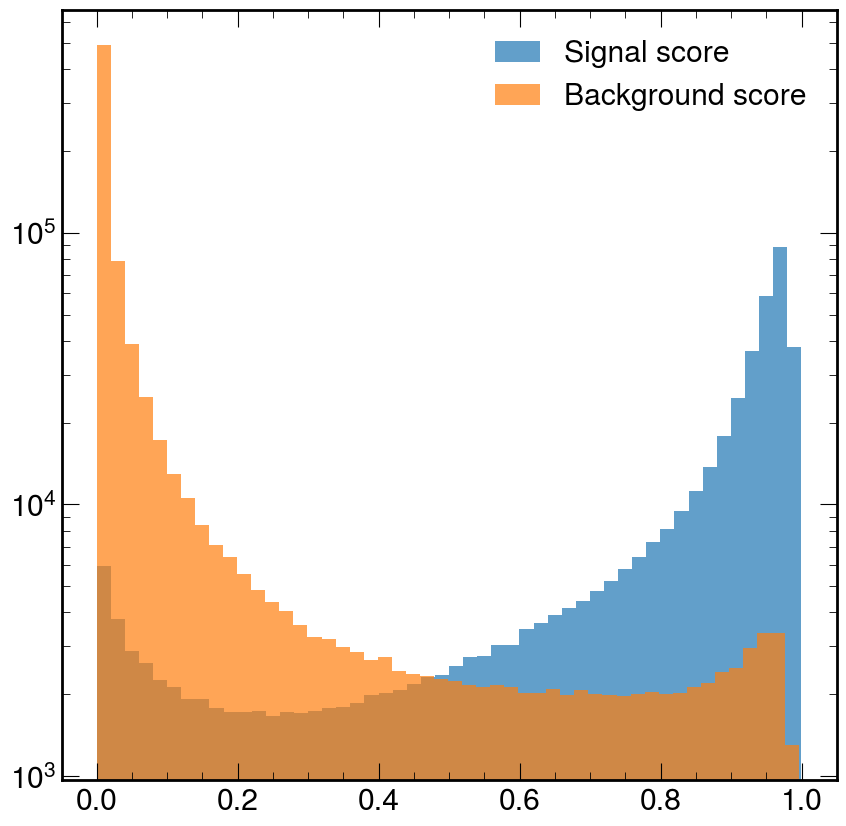

In [8]:
plt.style.use(hep.style.ROOT)
plt.hist(S_score_te, 50, label='Signal score', alpha=0.7)
plt.hist(B_score_te, 50, label='Background score', alpha=0.7)
plt.semilogy()
plt.legend()
plt.savefig(f'{fold}/Scoring.png',bbox_inches='tight')

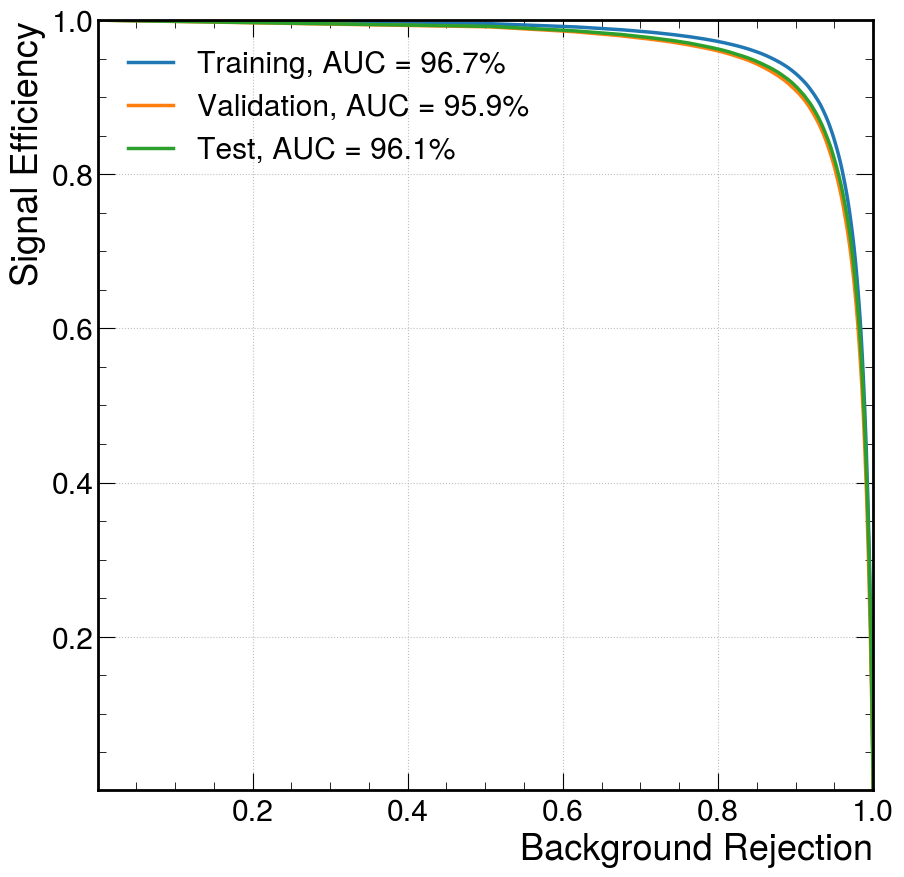

<Figure size 1000x1000 with 0 Axes>

In [9]:
plt.style.use(hep.style.ROOT)
plt.figure()
plt.plot(Brej_tr, Seff_tr, lw=2.5, label="Training, AUC = {:.1f}%".format(auc(Brej_tr,Seff_tr)*100))
plt.plot(Brej_vl, Seff_vl, lw=2.5, label="Validation, AUC = {:.1f}%".format(auc(Brej_vl,Seff_vl)*100))
plt.plot(Brej_te, Seff_te, lw=2.5, label="Test, AUC = {:.1f}%".format(auc(Brej_te,Seff_te)*100))
plt.xlabel(r'Background Rejection')
plt.ylabel(r'Signal Efficiency')
#plt.semilogx()
plt.ylim(0.001, 1)
plt.xlim(0.001, 1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()
plt.savefig(f'{fold}/ROC2.png',bbox_inches='tight')

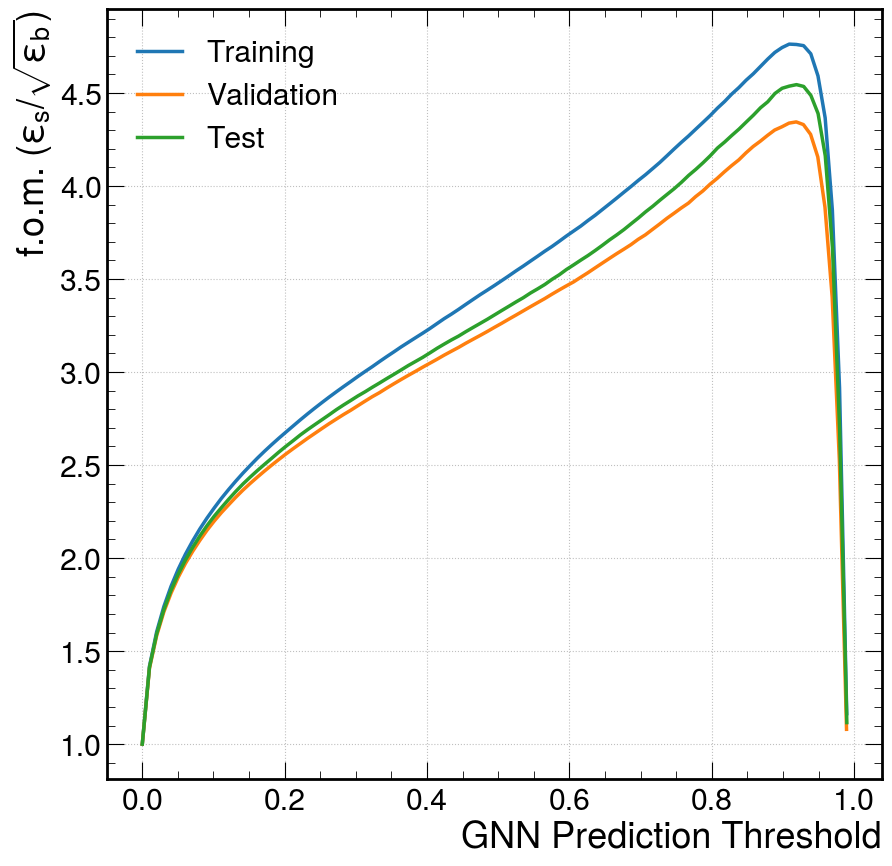

<Figure size 1000x1000 with 0 Axes>

In [10]:
plt.style.use(hep.style.ROOT)
plt.figure()
plt.plot(thre_tr, Figm_tr, lw=2.5, label = "Training")
plt.plot(thre_vl, Figm_vl, lw=2.5, label = "Validation")
plt.plot(thre_te, Figm_te, lw=2.5, label = "Test")
plt.xlabel(r'GNN Prediction Threshold')
plt.ylabel(r'f.o.m. ($\epsilon_{s}/\sqrt{\epsilon_{b}}$)')
plt.grid(True)
plt.legend()
plt.show()
plt.savefig(f'{fold}/FOM.png',bbox_inches='tight')

In [11]:
fom   = [x for x in Figm_te if x!=np.inf]
xmax  = thre_te[np.argmax(fom)]
NBins = 10
EBins = np.linspace(min(E),max(E),NBins+1)
E_sorted, keys_e = zip(*sorted(zip(E,range(0,len(y_test)))))
ERS   = []
ERB   = []

for i in tqdm(range(0,NBins)):
    keys_ei = keys_e[len([x for x in E if x<=EBins[i]]):len([x for x in E if x<=EBins[i+1]])]
    a       = np.array([y_test[x]    for x in keys_ei])
    b       = np.array([y_predict[x] for x in keys_ei])
    PredS   = np.array([a[i] for i in range(0,len(a)) if b[i]>=xmax])
    PredB   = np.array([a[i] for i in range(0,len(a)) if b[i]<xmax])
    try:
        ERS.append(len(PredS[PredS==1])/len(a[a==1]))
    except:
        ERS.append(0)
    try:
        ERB.append(len(PredB[PredB==0])/len(a[a==0]))
    except:
        ERB.append(0)

  0%|          | 0/10 [00:00<?, ?it/s]

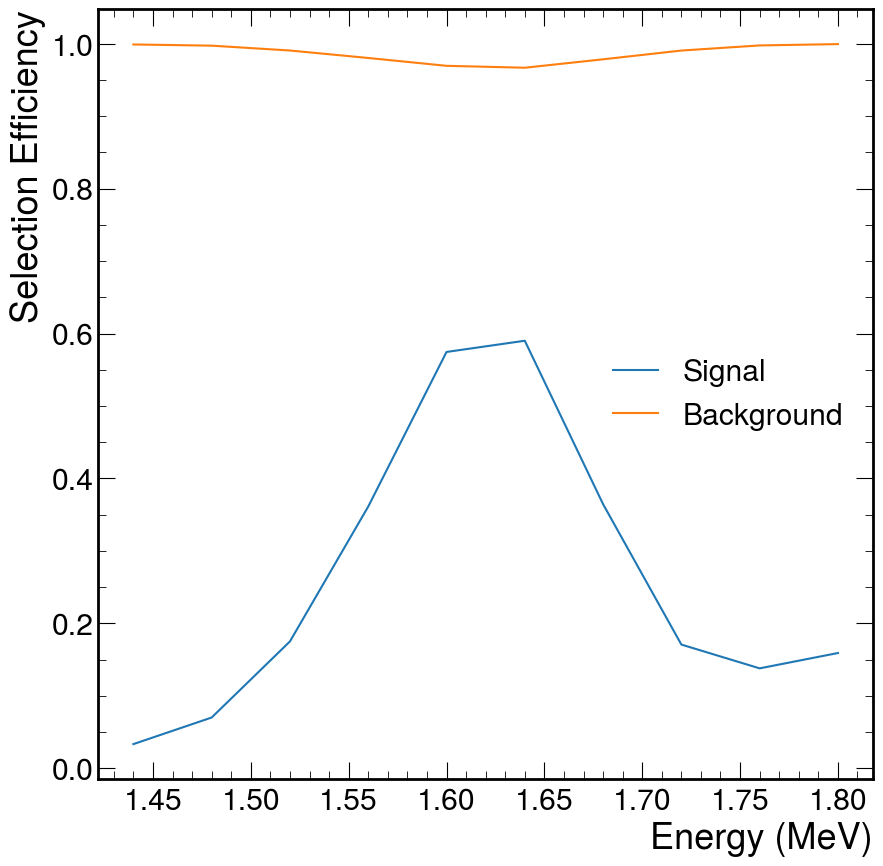

In [12]:
plt.style.use(hep.style.ROOT)

plt.plot(EBins[1:],ERS,label='Signal')
plt.plot(EBins[1:],ERB,label='Background')
plt.ylabel('Selection Efficiency')
plt.xlabel('Energy (MeV)')
plt.legend()
plt.savefig(f'{fold}/Efficiency.png',bbox_inches='tight')

In [13]:
S           = []
B           = []
for i in tqdm(range(0,len(E))):
    if y_predict[i]<xmax:
        B.append(E[i])
    else:
        S.append(E[i])

  0%|          | 0/1229420 [00:00<?, ?it/s]

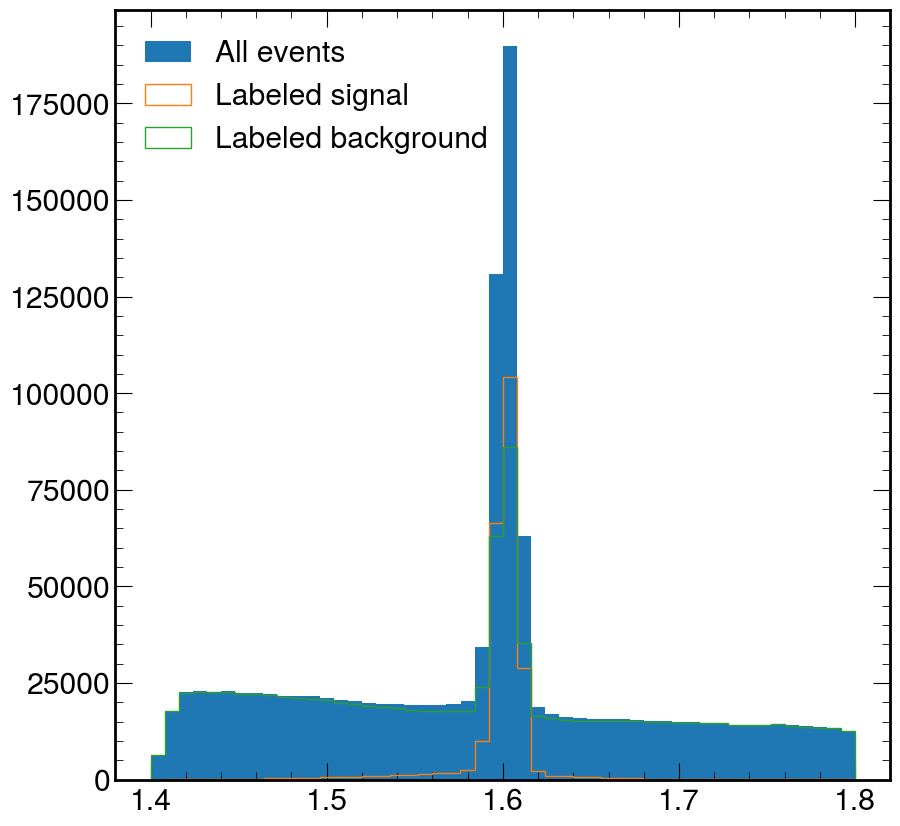

In [14]:
plt.hist(E,50,label='All events')
plt.hist(S,50,histtype='step',label='Labeled signal')
plt.hist(B,50,histtype='step',label='Labeled background');
plt.legend()

In [15]:
Seff_te[np.argmax(fom)]

0.5248764330134393

In [16]:
Brej_te[np.argmax(fom)]

0.9866647242735637

In [17]:
max(fom)

4.545232186893846

In [18]:
thre_PN = thre_te
Figm_PN = Figm_te
Seff_PN = Seff_te
Brej_PN = Brej_te
%store thre_PN
%store Figm_PN
%store Seff_PN
%store Brej_PN

Stored 'thre_PN' (ndarray)
Stored 'Figm_PN' (list)
Stored 'Seff_PN' (list)
Stored 'Brej_PN' (list)
